In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl

import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import OneCycleLR
from torch_geometric.nn import MessagePassing
from torch.nn import Sequential as Seq, Linear as Lin, Tanh
from torch.autograd import Variable
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

from sklearn.model_selection import train_test_split

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

/opt/anaconda3/envs/pytorchenv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data preparation and model setup

In [3]:
Re = '0'
#We provide datasets for phi in {0.064, 0.125, 0.216, 0.343}
phi = '0.064'
#If nodeupdate == False: y=f(x); If nodeupdate == True: y=f(g(x))
nodeupdate = True
#In all our experiments for this paper, we set "spherical" to True, so that Cartesian coordinates are converted to spherical. 
spherical = True

n_particles = 30
n_neighbors = n_particles-1

def augment_data(X, n):
    X_rot = np.zeros((0, X.shape[1]))
    theta_vec = np.linspace(0, 2*np.pi, n)[1:-1]
    for theta in theta_vec:
        X_tmp = np.zeros(X.shape)
        for i in range(0, X.shape[1], 3):
            X_tmp[:, i] = X[:, i]
        for i in range(1, X.shape[1], 3):
            X_tmp[:, i] = X[:, i+1] * np.sin(theta) + X[:, i] * np.cos(theta)
        for i in range(2, X.shape[1], 3):
            X_tmp[:, i] = X[:, i] * np.cos(theta) - X[:, i-1] * np.sin(theta)
        X_rot = np.vstack((X_rot, X_tmp))

    return np.vstack((X, X_rot))


def convert_to_spherical(X):
    ptsnew = np.zeros(X.shape)
    ptsnew[:,:,0] = np.sqrt(X[:,:,0]**2 + X[:,:,1]**2 + X[:,:,2]**2)
    ptsnew[:,:,1] = np.arctan2(np.sqrt(X[:,:,1]**2 + X[:,:,2]**2), X[:,:,0]) # for elevation angle defined from Z-axis down
    ptsnew[:,:,2] = np.arctan2(X[:,:,2], X[:,:,1])
    
    return ptsnew

dataset = pd.read_csv(f'./GNN_data_inhouse/Re{Re.replace(".","")}_phi{phi.replace(".","")}_train.csv',
                            header=0).values.astype(np.float32)

neighbors = dataset[:,15:-3]
forces = dataset[:,-3:]
u = dataset[:,9:12]
part_radius = dataset[:,5][0]

dataset = np.concatenate((neighbors, u, forces), axis = 1)
dataset = augment_data(dataset, 7)
if spherical == True:
    X = dataset[:, :n_neighbors*3]
    X = X.reshape((X.shape[0], X.shape[1]//3, 3))
    X = convert_to_spherical(X)
    V = dataset[:, -6:-3]
    V = V.reshape((V.shape[0], V.shape[1]//3, 3))
    X = np.concatenate((V, X), axis = 1)
else:
    X = dataset[:, :n_neighbors*3]
    V = dataset[:, -6:-3]
    X = np.concatenate((V, X), axis = 1)
    X = X.reshape((X.shape[0], X.shape[1]//3, 3))
X = torch.from_numpy(X).float()

y = dataset[:, [-3]]
y = y.reshape((y.shape[0], 1, 1))
y_mean = y.mean()
y -= y_mean
y = torch.from_numpy(y).float()

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)


def get_edge_index(n):
    # n = total number of particles, including particle in focus
    # all neighboring particles i > 0 are connected to particle 0 in the center
    top = torch.arange(1, n)
    bottom = torch.from_numpy(np.zeros(n-1))
    edge_index = torch.cat((top[None], bottom[None]), dim=0)

    return edge_index.long()

In [4]:
print(X_train.shape)
print(X_test.shape)

torch.Size([2250, 30, 3])
torch.Size([750, 30, 3])


In [5]:
class GNN_nodeupdate(MessagePassing):
  def __init__(self, in_features: int=3, out_features: int=1, hidden: int=30, edge_index: torch.long = None, aggr = 'add'):
    super().__init__(aggr=aggr)
    self.in_features = in_features
    self.out_features = out_features
    self.edge_index = edge_index

    #define shared message function block as an mlp
    self.shared_msg = Seq(
        Lin(in_features = 2*in_features, out_features = hidden),
        Tanh(),
        Lin(in_features = hidden, out_features = hidden),
        Tanh(),
        Lin(in_features = hidden, out_features = out_features, bias = False))

    self.node_fnc = Seq(
        Lin(in_features = 4, out_features = hidden),
        Tanh(),
        Lin(in_features = hidden, out_features = hidden),
        Tanh(),
        Lin(in_features = hidden, out_features = 1, bias = False))

  def forward(self, x, edge_index):
    #shape of x is [n_particles, in_features]
    #self.propagate calls:
    #   self.message
    #   self.aggregate (aggregation function defined in __init__)
    #   self.update
    return self.propagate(edge_index, x=x)

  def message(self, x_i, x_j):
    # x_i has shape [n_e, n_f]; x_j has shape [n_e, n_f]
    tmp = torch.cat([x_i, x_j], dim=1)  # tmp has shape [E, 2 * in_features]
    return self.shared_msg(tmp)

  def update(self, aggr_out, x=None):
    # aggr_out has shape [n, msg_dim]

    tmp = torch.cat([x, aggr_out], dim=1)
    return self.node_fnc(tmp) #[n, nupdate]

class GNN_edgeonly(MessagePassing):
  def __init__(self, in_features: int=3, out_features: int=1, hidden: int=30, edge_index: torch.long = None, aggr = 'add'):
    super().__init__(aggr=aggr)
    self.in_features = in_features
    self.out_features = out_features
    self.edge_index = edge_index

    #define shared message function block as an mlp
    self.shared_msg = Seq(
        Lin(in_features = 2*in_features, out_features = hidden),
        Tanh(),
        Lin(in_features = hidden, out_features = hidden),
        Tanh(),
        Lin(in_features = hidden, out_features = out_features, bias = False))

  def forward(self, x, edge_index):
    #shape of x is [n_particles, in_features]
    #self.propagate calls:
    #   self.message
    #   self.aggregate (aggregation function defined in __init__)
    #   self.update
    return self.propagate(edge_index, x=x)

  def message(self, x_i, x_j):
    # x_i has shape [n_e, n_f]; x_j has shape [n_e, n_f]
    tmp = torch.cat([x_i, x_j], dim=1)  # tmp has shape [E, 2 * in_features]
    return self.shared_msg(tmp)


### Test model 

In [6]:
in_features = X_train.shape[-1]
out_features = 1
edge_index = get_edge_index(n_particles)
aggr = 'add'

q = Data(x = X_train[0], edge_index=edge_index, y=y_train[0])
if nodeupdate == True:
    model = GNN_nodeupdate(in_features, out_features, edge_index=edge_index, aggr=aggr)
else:
    model = GNN_edgeonly(in_features, out_features, edge_index=edge_index, aggr=aggr)


In [8]:
# Test model
print(model.forward(q.x, q.edge_index).shape)
print('---')
print(q.y.shape)
print('---')
y = q.y
y_ = model.forward(q.x, q.edge_index)
print(torch.sum(torch.abs(y - y_[0])))

torch.Size([30, 1])
---
torch.Size([1, 1])
---
tensor(0.0959, grad_fn=<SumBackward0>)


In [9]:
batch_size = 100
# Used for batch-wise training
trainloader = DataLoader(
    [Data(Variable(X_train[i]), edge_index=edge_index, y=Variable(y_train[i])) for i in range(len(y_train))],
    batch_size=batch_size,
    shuffle=True)

# Used for testing and message recording
testloader = DataLoader(
    [Data(X_test[i], edge_index=edge_index, y=y_test[i]) for i in range(len(y_test))],
    batch_size= len(y_test),
    shuffle=True)

### Define message recording function (this data is later on used to train the GP)

In [10]:
def message_recording(model, loader):
    with torch.no_grad():
        for batch in loader:
            model.cpu()
            sending_particle_data = batch.x[batch.edge_index[0]]
            receiving_particle_data = batch.x[batch.edge_index[1]]
            y = batch.y
            y = y.expand(y.shape[0], n_neighbors)
            y = torch.reshape(y, shape=(y.size(0)*n_neighbors, 1))
            #print(sending_particle_data.shape)
            tmp = torch.cat([receiving_particle_data, sending_particle_data], dim=1)
            #print(tmp.shape)
            message = model.shared_msg(tmp)
            #print(message.shape)
            all_data = torch.cat((sending_particle_data, receiving_particle_data, message, y), dim=1)
            if spherical == True:
                columns = ['r', 'theta', 'phi', 'u_x', 'u_y', 'u_z']
            else:
                columns = ['x', 'y', 'z' , 'u_x', 'u_y', 'u_z']
            columns += ['F_i', 'F_true']
    return pd.DataFrame(data=all_data.cpu().detach().numpy(),columns=columns)

In [11]:
loss_fn = torch.nn.MSELoss()
lr = 2.0e-3
epochs = 5000
cuteLittleAdam = Adam(model.parameters(), lr=lr)  
sched = OneCycleLR(cuteLittleAdam, max_lr=lr, steps_per_epoch=len(trainloader), epochs=epochs, final_div_factor=1e5)

# Use GPU for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

def R2(y_pred, y_true):
    SS_res =  torch.sum(torch.square(y_true - y_pred)) 
    SS_tot = torch.sum(torch.square(y_true - torch.mean(y_true))) 
    return 1 - SS_res / (SS_tot + 1e-30) #add tiny value to avoid division by 0

def accuracy(loader, model):
    losses = []
    r2s = []
    for batch in loader:
      with torch.no_grad():
        # Compute model prediction
        pred = model(batch.x.float(), batch.edge_index) 
        # Do the reshaping because we only want to predict the property of the center node
        pred = pred.reshape((batch.num_graphs, len(pred)//batch.num_graphs))
        y_pred_center = pred[:,0].reshape((len(pred),1))
        # Compute loss and R^2 of prediction
        loss = loss_fn(y_pred_center, batch.y)
        r2 = R2(y_pred_center, batch.y)
        losses.append(loss)
        r2s.append(r2)
    loss = sum(losses)/len(losses)
    r2 = sum(r2s)/len(r2s)
    
    return loss, r2

In [12]:
r2_prev = 0
r2_earlystop_count = 0
msg_archive = []

for epoch in range(1,epochs+1):
    for batch in trainloader:
      # Use GPU
      batch.to(device)  
      # Reset gradients
      cuteLittleAdam.zero_grad() 
      # Passing the node features and the connection info
      pred = model(batch.x.float(), batch.edge_index) 
      # Calculating the loss and gradients
      # Do the reshaping because we only want to predict the property of the center node
      pred = pred.reshape((batch.num_graphs, len(pred)//batch.num_graphs))
      y_pred_center = pred[:,0].reshape((len(pred),1))
      # Compute loss and backpropagate
      loss = loss_fn(y_pred_center, batch.y)    
      loss.backward()  
      # Update using the gradients
      cuteLittleAdam.step()
      sched.step()
    
    #Store message values 
    msg = message_recording(model, testloader)
    msg_archive.append(msg)

    #Early Stopping Check
    loss_test, r2_test = accuracy(testloader, model)
    if r2_test < r2_prev:
      r2_earlystop_count += 1
      if r2_earlystop_count == 10:
        print('Early Stopping reached')
        break
    else: 
      r2_earlystop_count = 0
    r2_prev = r2_test

    if epoch % 100 == 0:
      #go through entire train and test set for trustworthy report of train and test accuracy
      loss_train, r2_train = accuracy(trainloader, model)
      loss_test, r2_test = accuracy(testloader, model)
      print(f"Epoch {epoch} | Train Loss {loss_train} | Train R^2 {r2_train}  | Test Loss {loss_test} | Test R^2 {r2_test}")

Epoch 100 | Train Loss 0.0009155666921287775 | Train R^2 0.2052535116672516  | Test Loss 0.0008727062377147377 | Test R^2 0.21192634105682373
Epoch 200 | Train Loss 0.000496970780659467 | Train R^2 0.5647587776184082  | Test Loss 0.00048004623386077583 | Test R^2 0.5665073394775391
Epoch 300 | Train Loss 0.00042780261719599366 | Train R^2 0.6259633898735046  | Test Loss 0.00043359596747905016 | Test R^2 0.6084529161453247
Epoch 400 | Train Loss 0.0004518851637840271 | Train R^2 0.5952945947647095  | Test Loss 0.00044001310016028583 | Test R^2 0.6026581525802612
Epoch 500 | Train Loss 0.0005776099860668182 | Train R^2 0.487554132938385  | Test Loss 0.0005942113930359483 | Test R^2 0.4634135961532593
Epoch 600 | Train Loss 0.00036268195253796875 | Train R^2 0.683306097984314  | Test Loss 0.0003694447223097086 | Test R^2 0.6663830280303955
Epoch 700 | Train Loss 0.000466162950033322 | Train R^2 0.5880931615829468  | Test Loss 0.00047543272376060486 | Test R^2 0.570673406124115
Epoch 800 |

### Save model

In [11]:
filename = f'Re{Re.replace(".","")}_phi{phi.replace(".","")}'
if spherical == True:
    filename += '_spherical'
else:
    filename += '_cartesian'
if nodeupdate == True:
    filename += '_nodeupdate'
    
msg.to_csv(f'./GP_data/'+filename+'.csv', index=False)
pkl.dump(msg, open('./GNN_results/messages_'+filename+'.pkl', 'wb'))
pkl.dump(model.state_dict(), open('./GNN_results/model_'+filename+'.pkl', 'wb'))

### Load model

In [12]:
filename = f'Re{Re.replace(".","")}_phi{phi.replace(".","")}'
if spherical == True:
    filename += '_spherical'
else:
    filename += '_cartesian'
if nodeupdate == True:
    filename += '_nodeupdate'
    
msg = pkl.load(open('./GNN_results/messages_'+filename+'.pkl', 'rb'))
model_ = pkl.load(open('./GNN_results/model_'+filename+'.pkl', 'rb'))
if nodeupdate == True:
    model = GNN_nodeupdate(in_features, out_features, edge_index=edge_index, aggr=aggr)
else:
    model = GNN_edgeonly(in_features, out_features, edge_index=edge_index, aggr=aggr)
model.load_state_dict(model_)

<All keys matched successfully>

### Run some tests on the model

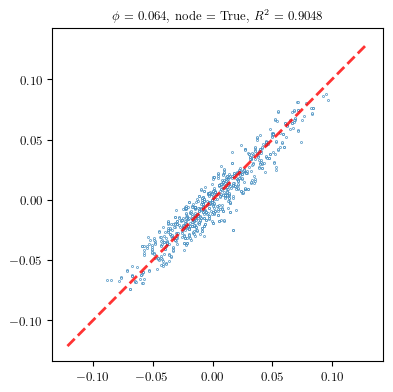

In [13]:
plt.rc('font', size='9')

for batch in testloader:
    with torch.no_grad():
        pred = model(batch.x.float(), batch.edge_index) 
        # Calculating the loss and gradients
        # Do the reshaping because we only want to predict the property of the center node
        pred = pred.reshape((batch.num_graphs, len(pred)//batch.num_graphs))
        y_pred_center = pred[:,0].reshape((len(pred),1))
        y = batch.y

        fig, ax1 = plt.subplots(figsize=(4,4), tight_layout=True)
        
        ax1.scatter(y, y_pred_center, marker='.', s=9, linewidth=0.5, alpha=0.8, edgecolor='tab:blue', facecolor='white')
        
        lim1 = torch.min(y)-torch.std(y)
        lim2 = torch.max(y)+torch.std(y)
        ax1.plot([lim1, lim2], [lim1, lim2], linestyle='--', color='red', linewidth=2, alpha=0.8)
        r2 = R2(y_pred_center, y)
        ax1.set_title('$\phi$ = ' + phi +', nodeupdate = '+str(nodeupdate)+', $R^2$ = '+str(r2.round(decimals=5).numpy()), size = 9)